<a href="https://colab.research.google.com/github/GawainGan/Stock-Markets-Analytics/blob/main/Code/Module4/Module4_Part2_HyperTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Installs

In [ ]:
!pip install yfinance

In [ ]:
# read files shared via google-drive-link
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab

!pip uninstall gdown -y && pip install gdown
!gdown -V

Found existing installation: gdown 5.1.0
Uninstalling gdown-5.1.0:
  Successfully uninstalled gdown-5.1.0
gdown 5.2.0 at /usr/local/lib/python3.10/dist-packages


In [ ]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# measure time for ML HyperParams search
import time
from datetime import date

# ML models and utils
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# 0) One DataFrame with Dummies
* including newly defined "month-week_of_month"

## 0.1) Read and truncate data (last 25 years from 2000), define variable sets


In [ ]:
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab
# truncated data from Module 2: https://drive.google.com/file/d/1m3Qisfs2XfWk6Sw_Uk5kHLWqwQ0q8SKb/view?usp=sharing
!gdown https://drive.google.com/file/d/1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP/view?usp=sharing --fuzzy -O /content/

Downloading...
From (original): https://drive.google.com/uc?id=1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP
From (redirected): https://drive.google.com/uc?id=1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP&confirm=t&uuid=0a0664ac-6117-4fa7-83df-72a49e1a03e9
To: /content/stocks_df_combined_2024_05_07.parquet.brotli
100% 119M/119M [00:03<00:00, 31.5MB/s]


In [ ]:
# truncated
# df = pd.read_parquet("/content/stocks_df_combined_trunc_2014_2023.parquet.brotli", )

# full dataset for 33 stocks
df_full = pd.read_parquet("/content/stocks_df_combined_2024_05_07.parquet.brotli", )

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221142 entries, 0 to 5426
Columns: 202 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(128), int32(64), int64(5), object(2)
memory usage: 288.5+ MB


In [ ]:
# growth indicators (but not future growth)
GROWTH = [g for g in df_full.keys() if (g.find('growth_')==0)&(g.find('future')<0)]
GROWTH

['growth_1d',
 'growth_3d',
 'growth_7d',
 'growth_30d',
 'growth_90d',
 'growth_365d',
 'growth_dax_1d',
 'growth_dax_3d',
 'growth_dax_7d',
 'growth_dax_30d',
 'growth_dax_90d',
 'growth_dax_365d',
 'growth_snp500_1d',
 'growth_snp500_3d',
 'growth_snp500_7d',
 'growth_snp500_30d',
 'growth_snp500_90d',
 'growth_snp500_365d',
 'growth_dji_1d',
 'growth_dji_3d',
 'growth_dji_7d',
 'growth_dji_30d',
 'growth_dji_90d',
 'growth_dji_365d',
 'growth_epi_1d',
 'growth_epi_3d',
 'growth_epi_7d',
 'growth_epi_30d',
 'growth_epi_90d',
 'growth_epi_365d',
 'growth_gold_1d',
 'growth_gold_3d',
 'growth_gold_7d',
 'growth_gold_30d',
 'growth_gold_90d',
 'growth_gold_365d',
 'growth_wti_oil_1d',
 'growth_wti_oil_3d',
 'growth_wti_oil_7d',
 'growth_wti_oil_30d',
 'growth_wti_oil_90d',
 'growth_wti_oil_365d',
 'growth_brent_oil_1d',
 'growth_brent_oil_3d',
 'growth_brent_oil_7d',
 'growth_brent_oil_30d',
 'growth_brent_oil_90d',
 'growth_brent_oil_365d',
 'growth_btc_usd_1d',
 'growth_btc_usd_3d',


In [ ]:
# leaving only Volume ==> generate ln(Volume)
OHLCV = ['Open','High','Low','Close','Adj Close_x','Volume']

In [ ]:
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']

In [ ]:
df_full.growth_future_5d.describe()

count    220977.000000
mean          1.004630
std           0.051592
min           0.412383
25%           0.979594
50%           1.003802
75%           1.028273
max           3.018887
Name: growth_future_5d, dtype: float64

In [ ]:
# 54% of data records have positive future growth>0
df_full.is_positive_growth_5d_future.mean()

0.5411319423718697

In [ ]:
# moving to strong growth (54% -> ~ 32%)
df_full.growth_future_5d.quantile(0.68)

1.0202201074172228

In [ ]:
# TODO HA4 Q3: Define a new variable 'is_strong_positive_growth_5d_future' according to the task
#  it will be automatically added the the list TO_PREDICT

In [ ]:
TO_PREDICT = [g for g in df_full.keys() if (g.find('future')>=0)]
TO_PREDICT

['growth_future_5d', 'is_positive_growth_5d_future']

In [ ]:
TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Adj Close_y'] + CATEGORICAL + OHLCV
TO_DROP

['Year',
 'Date',
 'index_x',
 'index_y',
 'index',
 'Quarter',
 'Adj Close_y',
 'Month',
 'Weekday',
 'Ticker',
 'ticker_type',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj Close_x',
 'Volume']

In [ ]:
# let's define on more custom numerical features
df_full['ln_volume'] = df_full.Volume.apply(lambda x: np.log(x))

In [ ]:
# manually defined features
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']

In [ ]:
# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']

In [ ]:
TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')

Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']


In [ ]:
MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']

In [ ]:
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

In [ ]:
# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df_full.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP + TO_PREDICT]
OTHER

[]

In [ ]:
df_full.Ticker.nunique()

33

In [ ]:
# truncated df_full with 25 years of data (and defined growth variables)
df = df_full[df_full.Date>='2000-01-01']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 203 entries, Open to ln_volume
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 239.7+ MB


## 0.2) Dummies

In [ ]:
# dummy variables can't be generated from Date and numeric variables ==> convert to STRING (to define groups for Dummies)
df.loc[:,'Month'] = df.Month.dt.strftime('%B')
df.loc[:,'Weekday'] = df.Weekday.astype(str)

### 0.2.1) Create a new string column 'month_wom' (month_week_of_month)

In [ ]:
# define week of month
df.loc[:,'wom'] = df.Date.apply(lambda d: (d.day-1)//7 + 1)
# convert to string
df.loc[:,'wom'] = df.loc[:,'wom'].astype(str)

In [ ]:
# check values for week-of-month (should be between 1 and 5)
df.wom.value_counts()

wom
2    42817
3    42007
4    41715
1    41490
5    14646
Name: count, dtype: int64

In [ ]:
df.loc[:,'month_wom'] = df.Month + '_w' + df.wom

In [ ]:
# examples of encoding
df.month_wom.value_counts()[0:2]

month_wom
February_w1    3705
January_w2     3686
Name: count, dtype: int64

In [ ]:
# del wom temp variable
del df['wom']

### 0.2.2) Generate all dummies

In [ ]:
# what are the categorical features?
CATEGORICAL.append('month_wom')
CATEGORICAL

['Month', 'Weekday', 'Ticker', 'ticker_type', 'month_wom']

In [ ]:
# Generate dummy variables (no need for bool, let's have int32 instead)
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')

In [ ]:
dummy_variables.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 115 entries, Month_April to month_wom_September_w5
dtypes: int32(115)
memory usage: 81.5 MB


In [ ]:
# get dummies names in a list
DUMMIES = dummy_variables.keys().to_list()
DUMMIES

['Month_April',
 'Month_August',
 'Month_December',
 'Month_February',
 'Month_January',
 'Month_July',
 'Month_June',
 'Month_March',
 'Month_May',
 'Month_November',
 'Month_October',
 'Month_September',
 'Weekday_0',
 'Weekday_1',
 'Weekday_2',
 'Weekday_3',
 'Weekday_4',
 'Weekday_5',
 'Weekday_6',
 'Ticker_AAPL',
 'Ticker_ACN',
 'Ticker_AMZN',
 'Ticker_ASML',
 'Ticker_AVGO',
 'Ticker_BHARTIARTL.NS',
 'Ticker_BRK-B',
 'Ticker_CDI.PA',
 'Ticker_GOOG',
 'Ticker_HDB',
 'Ticker_HINDUNILVR.NS',
 'Ticker_IBN',
 'Ticker_IDEXY',
 'Ticker_INFY',
 'Ticker_ITC.NS',
 'Ticker_JPM',
 'Ticker_LICI.NS',
 'Ticker_LLY',
 'Ticker_LT.NS',
 'Ticker_MC.PA',
 'Ticker_META',
 'Ticker_MSFT',
 'Ticker_NVDA',
 'Ticker_NVO',
 'Ticker_OR.PA',
 'Ticker_RELIANCE.NS',
 'Ticker_RMS.PA',
 'Ticker_SAP',
 'Ticker_SBIN.NS',
 'Ticker_SIE.DE',
 'Ticker_TCS.NS',
 'Ticker_TTE',
 'Ticker_V',
 'ticker_type_EU',
 'ticker_type_INDIA',
 'ticker_type_US',
 'month_wom_April_w1',
 'month_wom_April_w2',
 'month_wom_April_w3',
 'mo

In [ ]:
len(DUMMIES)

115

In [ ]:
# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df, dummy_variables], axis=1)

In [ ]:
df_with_dummies[NUMERICAL+DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 299 entries, growth_1d to month_wom_September_w5
dtypes: float64(121), int32(177), int64(1)
memory usage: 294.8 MB


### 0.2.3 Define "DUMMIES_SHORT"

In [ ]:
# TODO HA4 Q2: Define DUMMIES_SHORT from DUMMIES -- all elements: without month_* and Ticker_*
DUMMIES_SHORT=[]
DUMMIES_SHORT = [col for col in DUMMIES if not (col.startswith('month_') or col.startswith('Ticker'))]
DUMMIES_SHORT

['Month_April',
 'Month_August',
 'Month_December',
 'Month_February',
 'Month_January',
 'Month_July',
 'Month_June',
 'Month_March',
 'Month_May',
 'Month_November',
 'Month_October',
 'Month_September',
 'Weekday_0',
 'Weekday_1',
 'Weekday_2',
 'Weekday_3',
 'Weekday_4',
 'Weekday_5',
 'Weekday_6',
 'ticker_type_EU',
 'ticker_type_INDIA',
 'ticker_type_US']

In [ ]:
# now check the size of the dataset
df_with_dummies[NUMERICAL+DUMMIES_SHORT].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 206 entries, growth_1d to ticker_type_US
dtypes: float64(121), int32(84), int64(1)
memory usage: 230.0 MB


### 0.2.4) Temporal split

In [ ]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.7).
        val_prop (float): Proportion of data for validation set (default: 0.15).
        test_prop (float): Proportion of data for test set (default: 0.15).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

In [ ]:
min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [ ]:
# the split is approximate!
  # as tickers can have a different history
df_with_dummies['split'].value_counts()/len(df_with_dummies)

split
train         0.675834
test          0.163290
validation    0.160876
Name: count, dtype: float64

In [ ]:
# remove the "segmentation" problem (warning message on df performance after many joins and data transformations)
new_df = df_with_dummies.copy()

In [ ]:
# EXACT DATES for the split:
# time split on train/validation/test: FIXED dates of split, approx. 70%, 15%, 15% split
new_df.groupby(['split'])['Date'].agg({'min','max','count'})

,count,max,min
split,,,
test,29829,2024-05-07,2020-09-14
train,123458,2017-01-16,2000-01-03
validation,29388,2020-09-11,2017-01-17


In [ ]:
# Full dataframe (transformed and truncated to 25 years)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 320 entries, Open to split
dtypes: datetime64[ns](2), float64(129), int32(178), int64(5), object(6)
memory usage: 323.3+ MB


In [ ]:
# check one record: it has abs. values, text, and numbers
new_df.head(1)

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,month_wom_October_w2,month_wom_October_w3,month_wom_October_w4,month_wom_October_w5,month_wom_September_w1,month_wom_September_w2,month_wom_September_w3,month_wom_September_w4,month_wom_September_w5,split
3490,58.6875,59.3125,56.0,58.28125,36.065567,53228400.0,MSFT,2000,January,0,...,0,0,0,0,0,0,0,0,0,train


In [ ]:
# what do we try to predict
new_df[TO_PREDICT].head(1)

,growth_future_5d,is_positive_growth_5d_future
3490,0.963003,0


### 0.2.5 Define dataframes for Modeling (ML) and cleane them

In [ ]:
# Features to be used in predictions (incl. new dummies)

# TODO HA4 Q2: use correct dummies here : DUMMIES_SHOR

#features_list = NUMERICAL+DUMMIES
features_list = NUMERICAL+DUMMIES_SHORT

# What we're trying to predict?

# TODO HA4 Q3: use correct feature to predict 'is_strong_positive_growth_5d_future'

to_predict = 'is_positive_growth_5d_future'

train_df = new_df[new_df.split.isin(['train'])].copy(deep=True)
valid_df = new_df[new_df.split.isin(['validation'])].copy(deep=True)
train_valid_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)

test_df =  new_df[new_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
X_train = train_df[features_list+[to_predict]]
X_valid = valid_df[features_list+[to_predict]]

X_train_valid = train_valid_df[features_list+[to_predict]]

X_test = test_df[features_list+[to_predict]]

# this to be used for predictions and join to the original dataframe new_df
X_all =  new_df[features_list+[to_predict]].copy(deep=True)

print(f'length: X_train {X_train.shape},  X_validation {X_valid.shape}, X_test {X_test.shape}, X_train_valid = {X_train_valid.shape},  all combined: X_all {X_all.shape}')

length: X_train (123458, 207),  X_validation (29388, 207), X_test (29829, 207), X_train_valid = (152846, 207),  all combined: X_all (182675, 207)


In [ ]:
# Prepare a dataframe for ML:
  # +-inf to NaN, all NaNs to 0s
def clean_dataframe_from_inf_and_nan(df:pd.DataFrame):
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
  df.fillna(0, inplace=True)
  return df

In [ ]:
# Clean from +-inf and NaNs:

X_train = clean_dataframe_from_inf_and_nan(X_train)
X_valid = clean_dataframe_from_inf_and_nan(X_valid)
X_train_valid = clean_dataframe_from_inf_and_nan(X_train_valid)
X_test = clean_dataframe_from_inf_and_nan(X_test)
X_all = clean_dataframe_from_inf_and_nan(X_all)

In [ ]:
y_train = X_train[to_predict]

y_valid = X_valid[to_predict]

y_train_valid = X_train_valid[to_predict]
y_test = X_test[to_predict]
y_all =  X_all[to_predict]

# remove y_train, y_test from X_ dataframes
del X_train[to_predict]
del X_valid[to_predict]
del X_train_valid[to_predict]

del X_test[to_predict]

del X_all[to_predict]

# 1) Modeling

## 1.1) Manual 'rule of thumb' predictions
* (pred0) CCI>200 (binary, on technical indicator CCI)
* (pred1) growth_1d>1
* (pred2) (growth_1d>1) & (growth_snp500_1d>1)
* (pred3) (gdppot_us_yoy <= 0.027) & (fastd >= 0.251)
* (pred4) (gdppot_us_yoy >= 0.027) & (growth_wti_oil_30d <= 1.005)

In [ ]:
# generate manual predictions
# Let's label all prediction features with prefix "pred"
new_df['pred0_manual_cci'] = (new_df.cci>200).astype(int)
new_df['pred1_manual_prev_g1'] = (new_df.growth_1d>1).astype(int)
new_df['pred2_manual_prev_g1_and_snp'] = ((new_df['growth_1d'] > 1) & (new_df['growth_snp500_1d'] > 1)).astype(int)
new_df['pred3_manual_gdp_and_fastd'] = ((new_df['gdppot_us_yoy'] <= 0.027) & (new_df['fastd'] >=0.251)).astype(int)
new_df['pred4_manual_gdp_and_wti30d'] = ((new_df['gdppot_us_yoy'] >= 0.027) & (new_df['growth_wti_oil_30d'] <= 1.005)).astype(int)

In [ ]:
# example output manual predictions:
new_df[['cci','growth_1d','growth_snp500_1d','pred0_manual_cci','pred1_manual_prev_g1','pred2_manual_prev_g1_and_snp','pred3_manual_gdp_and_fastd','pred4_manual_gdp_and_wti30d', to_predict]]

,cci,growth_1d,growth_snp500_1d,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_gdp_and_fastd,pred4_manual_gdp_and_wti30d,is_positive_growth_5d_future
3490,26.847237,0.998394,0.990451,0,0,0,0,0,0
3491,-34.319663,0.966220,0.961655,0,0,0,0,0,0
3492,-97.318008,1.010544,1.001922,0,1,1,0,0,0
3493,-169.947507,0.966502,1.000956,0,0,0,0,0,0
3494,-142.142685,1.013068,1.027090,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...
5422,-29.424989,0.988994,0.984269,0,0,0,1,0,0
5423,-26.657181,1.001447,1.009128,0,1,1,1,0,0
5424,-123.785473,0.972302,1.012557,0,0,0,1,0,0
5425,-181.986224,0.989571,1.010326,0,0,0,1,0,0


In [ ]:
# Function to find all predictions (starting from 'pred'), generate is_correct (correctness of each prediction)
# and precision on TEST dataset (assuming there is df["split"] column with values 'train','validation','test'

# returns 2 lists of features: PREDICTIONS and IS_CORRECT

def get_predictions_correctness(df:pd.DataFrame, to_predict:str):
  PREDICTIONS = [k for k in df.keys() if k.startswith('pred')]
  print(f'Prediction columns founded: {PREDICTIONS}')

  # add columns is_correct_
  for pred in PREDICTIONS:
    part1 = pred.split('_')[0] # first prefix before '_'
    df[f'is_correct_{part1}'] =  (new_df[pred] == new_df[to_predict]).astype(int)

  # IS_CORRECT features set
  IS_CORRECT =  [k for k in df.keys() if k.startswith('is_correct_')]
  print(f'Created columns is_correct: {IS_CORRECT}')

  print('Precision on TEST set for each prediction:')
  # define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
  for i,column in enumerate(IS_CORRECT):
    prediction_column = PREDICTIONS[i]
    is_correct_column = column
    filter = (new_df.split=='test') & (new_df[prediction_column]==1)
    print(f'Prediction column:{prediction_column} , is_correct_column: {is_correct_column}')
    print(new_df[filter][is_correct_column].value_counts())
    print(new_df[filter][is_correct_column].value_counts()/len(new_df[filter]))
    print('---------')

  return PREDICTIONS, IS_CORRECT

In [ ]:
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict = to_predict)

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_gdp_and_fastd', 'pred4_manual_gdp_and_wti30d']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    455
0    344
Name: count, dtype: int64
is_correct_pred0
1    0.569462
0    0.430538
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    8621
0    6980
Name: count, dtype: int64
is_correct_pred1
1    0.552593
0    0.447407
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    5726
0    4729
Name: count, dtype: int64
is_correct_pred2
1    0.547681
0    0.452319
Name: count, dtype: float64
-

In [ ]:
# TODO HA4 Q1: run prediction correctness for 'is_positive_growth_5d_future' (should be lower)

In [ ]:
new_df[PREDICTIONS+IS_CORRECT+[to_predict]]

,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_gdp_and_fastd,pred4_manual_gdp_and_wti30d,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,is_positive_growth_5d_future
3490,0,0,0,0,0,1,1,1,1,1,0
3491,0,0,0,0,0,1,1,1,1,1,0
3492,0,1,1,0,0,1,0,0,1,1,0
3493,0,0,0,0,0,1,1,1,1,1,0
3494,0,1,1,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
5422,0,0,0,1,0,1,1,1,0,1,0
5423,0,1,1,1,0,1,0,0,0,1,0
5424,0,0,0,1,0,1,1,1,0,1,0
5425,0,0,0,1,0,1,1,1,0,1,0


## 1.2) Decision Tree Classifier

### 1.2.1) Defining Functions to clean_df(), fit_decision_tree(), predict_decision_tree()
* here we discuss only the Decision Tree Classifier for binary predictions (and not the Regressor)

In [ ]:
# Estimation/fit function (using dataframe of features X and what to predict y) --> optimising total accuracy
# max_depth is hyperParameter
def fit_decision_tree(X, y, max_depth=20):
# Initialize the Decision Tree Classifier
  clf = DecisionTreeClassifier(max_depth=max_depth,
                               random_state=42)

  # Fit the classifier to the training data
  clf.fit(X, y)
  return clf, X.columns

In [ ]:
%%time
clf_10, train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=10)

CPU times: user 25.6 s, sys: 152 ms, total: 25.8 s
Wall time: 26.1 s


In [ ]:
# predict on a full dataset
y_pred_all = clf_10.predict(X_all)

In [ ]:
# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred5_clf_10'] = y_pred_all

In [ ]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict=to_predict)

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_gdp_and_fastd', 'pred4_manual_gdp_and_wti30d', 'pred5_clf_10']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    455
0    344
Name: count, dtype: int64
is_correct_pred0
1    0.569462
0    0.430538
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    8621
0    6980
Name: count, dtype: int64
is_correct_pred1
1    0.552593
0    0.447407
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    5726
0    4729
Name: count, dtype: int64
is_correct_pred2
1    0.547681
0    0.

## 1.2.3 Hyperparams tuning for a Decision Tree Classifier

In [ ]:
# visualisation: decision tree for a few levels (max_depth variable)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/20156951/how-do-i-find-which-attributes-my-tree-splits-on-when-using-scikit-learn
from sklearn.tree import export_text

In [ ]:
# %%time
# # hyper params tuning for a Decision Tree

precision_by_depth = {}
best_precision = 0
best_depth = 0

for depth in range(1,21):
    print(f'Working with a tree of a max depth= {depth}')
    # fitting the tree on X_train, y_train
    clf,train_columns = fit_decision_tree(X=X_train_valid,
                            y=y_train_valid,
                            max_depth=depth) #applying custom hyperparam
    # getting the predictions for TEST and accuracy score
    y_pred_valid = clf.predict(X_valid)
    precision_valid = precision_score(y_valid, y_pred_valid)
    y_pred_test = clf.predict(X_test)
    precision_test = precision_score(y_test, y_pred_test)
    print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')
    # saving to the dict
    precision_by_depth[depth] = round(precision_test,4)
    # updating the best precision
    if precision_test >= best_precision:
        best_precision = round(precision_test,4)
        best_depth = depth
#   # plot tree - long
#   # plt.figure(figsize=(20,10))  # Set the size of the figure
#   # plot_tree(clf,
#   #           filled=True,
#   #           feature_names=train_columns,
#   #           class_names=['Negative', 'Positive'],
#   #           max_depth=2)
#   # plt.show()
#   # plot tree - short
    #tree_rules = export_text(clf, feature_names=list(X_train), max_depth=3)
    #print(tree_rules)
    #print('------------------------------')


print(f'All precisions by depth: {precision_by_depth}')
print(f'The best precision is {best_precision} and the best depth is {best_depth} ')

Working with a tree of a max depth= 1
  Precision on test is 0.5551979617151095, (precision on valid is 0.5717299578059072 - tend to overfit)
Working with a tree of a max depth= 2
  Precision on test is 0.5552947488431359, (precision on valid is 0.5717299578059072 - tend to overfit)
Working with a tree of a max depth= 3
  Precision on test is 0.5551979617151095, (precision on valid is 0.5711741334429374 - tend to overfit)
Working with a tree of a max depth= 4
  Precision on test is 0.5552351895933215, (precision on valid is 0.5711741334429374 - tend to overfit)
Working with a tree of a max depth= 5
  Precision on test is 0.5554623258936063, (precision on valid is 0.5711741334429374 - tend to overfit)
Working with a tree of a max depth= 6
  Precision on test is 0.5711735485873952, (precision on valid is 0.5703184100130665 - tend to overfit)
Working with a tree of a max depth= 7
  Precision on test is 0.5683933475740006, (precision on valid is 0.5719782090568607 - tend to overfit)
Workin

In [ ]:
# UNCOMMENT TO RUN SEE THE RESULTS
# Results of Hyper parameters tuning for a Decision Tree
print(precision_by_depth)

{1: 0.5552, 2: 0.5553, 3: 0.5552, 4: 0.5552, 5: 0.5555, 6: 0.5712, 7: 0.5684, 8: 0.5684, 9: 0.5695, 10: 0.5657, 11: 0.5731, 12: 0.5723, 13: 0.5716, 14: 0.5834, 15: 0.5813, 16: 0.5663, 17: 0.5605, 18: 0.5626, 19: 0.57, 20: 0.5642}


In [ ]:
# pre-calculated results of Hyperparameter tuning: full dataset (300 features) and is_positive_growth_5d
precision_by_depth = {1: 0.5552, 2: 0.5553, 3: 0.5552, 4: 0.5552, 5: 0.5555, 6: 0.5712, 7: 0.5684, 8: 0.5684, 9: 0.57, 10: 0.5653, 11: 0.567, 12: 0.5719, 13: 0.5707, 14: 0.5845, 15: 0.5864, 16: 0.5721, 17: 0.5767, 18: 0.5682, 19: 0.5638, 20: 0.573}
best_depth = 15
best_precision = 0.5864

In [ ]:
print(f'Best precision and depth = {best_depth}, precision (on test)={best_precision}')

Best precision and depth = 15, precision (on test)=0.5864


In [ ]:
# TODO HA4 Q1: compare precision_by_depth with below? Any improvements? What's the optimal hyperparams?

In [ ]:
# TODO HA4 Q2: compare precision_by_depth with below? Any improvements? What's the optimal hyperparams?

In [ ]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(precision_by_depth.items()), columns=['max_depth', 'precision_score'])
df.loc[:,'precision_score'] = df.precision_score*100.0 # need for % visualisation

# Create the bar chart using Plotly Express
fig = px.bar(df,
             x='max_depth',
             y='precision_score',
            #  title='Precision Score vs. Max Depth for a Decision Tree',
             labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score'},
             range_y=[54, 60],
             text='precision_score')

# Update the text format to display as percentages
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Center the title
fig.update_layout(title={'text': 'Precision Score vs. Max Depth for a Decision Tree', 'x': 0.5, 'xanchor': 'center'})


# Show the figure
fig.show()

In [ ]:
%%time
clf_best,train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=best_depth)

CPU times: user 35.8 s, sys: 182 ms, total: 36 s
Wall time: 39.9 s


In [ ]:
# For a DecisionTreeClassifier in scikit-learn, the concept of trainable parameters differs from that of neural networks.
# In decision trees, the parameters are the structure of the tree itself (nodes and splits) rather than weights.
# However, you can still get a sense of the model's complexity by looking at the number of nodes and leaves.

# Here's how you can get this information for your trained DecisionTreeClassifier (referred to as clf_best):

# Get the number of nodes and leaves in the tree
n_nodes = clf_best.tree_.node_count
n_leaves = clf_best.get_n_leaves()

print(f"Number of nodes: {n_nodes}")
print(f"Number of leaves: {n_leaves}")

Number of nodes: 4197
Number of leaves: 2099


In [ ]:
clf_best

DecisionTreeClassifier(max_depth=14, random_state=42)

In [ ]:
# predict on a full dataset
y_pred_clf_best = clf_best.predict(X_all)

In [ ]:
# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred6_clf_best'] = y_pred_clf_best

In [ ]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict=to_predict)

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_gdp_and_fastd', 'pred4_manual_gdp_and_wti30d', 'pred5_clf_10', 'pred6_clf_best', 'pred7_clf_best_rule_66', 'pred8_clf_best_rule_78', 'pred9_rf_best_rule_55', 'pred10_rf_best_rule_60']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6', 'is_correct_pred7', 'is_correct_pred8', 'is_correct_pred9', 'is_correct_pred10']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    455
0    344
Name: count, dtype: int64
is_correct_pred0
1    0.569462
0    0.430538
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    8621
0    6980
Name: count, dtype: int64
is_correct_pred1
1    0.552593
0    0.447407
Na

## 1.3) Random Forest
https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles

In [ ]:
# (ALMOST 3 HOURS) UNCOMMENT BELOW TO RUN HYPERPARAMs optimisation again
# The best precision is 0.5778 and the best depth is 20
# CPU times: user 2h 48min 27s, sys: 31.9 s, total: 2h 48min 59s
# Wall time: 1h 39min 44s

In [ ]:
# %%time
# # hyper params tuning

precision_matrix = {}
best_precision = 0
best_depth = 0
best_estimators = 1

for depth in [15, 16, 17, 18, 19, 20]:
    for estimators in [50,100,200,500]:
        print(f'Working with HyperParams: depth = {depth}, estimators = {estimators}')

#     # Start timing
    start_time = time.time()
    # fitting the tree on X_train, y_train
    rf = RandomForestClassifier(n_estimators = estimators,
                                 max_depth = depth,
                                 random_state = 42,
                                 n_jobs = -1)

    rf = rf.fit(X_train_valid, y_train_valid)

    # getting the predictions for TEST and accuracy score
    y_pred_valid = rf.predict(X_valid)
    precision_valid = precision_score(y_valid, y_pred_valid)
    y_pred_test = rf.predict(X_test)
    precision_test = precision_score(y_test, y_pred_test)
    print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')

     # saving to the dict
    precision_matrix[depth, estimators] = round(precision_test,4)

    # Measure elapsed time
    elapsed_time = time.time() - start_time
    print(f'Time for training: {elapsed_time:.2f} seconds, or {elapsed_time/60:.2f} minutes')

#     # updating the best precision
    if precision_test >= best_precision:
        best_precision = round(precision_test,4)
        best_depth = depth
        best_estimators = estimators
        print(f'New best precision found for depth={depth}, estimators = {estimators}')

    print('------------------------------')

print(f'Matrix of precisions: {precision_matrix}')
print(f'The best precision is {best_precision} and the best depth is {best_depth} ')

Working with HyperParams: depth = 15, estimators = 50
Working with HyperParams: depth = 15, estimators = 100
Working with HyperParams: depth = 15, estimators = 200
Working with HyperParams: depth = 15, estimators = 500
  Precision on test is 0.5719126278211412, (precision on valid is 0.7637809926966553 - tend to overfit)
Time for training: 702.51 seconds, or 11.71 minutes
New best precision found for depth=15, estimators = 500
------------------------------
Working with HyperParams: depth = 16, estimators = 50
Working with HyperParams: depth = 16, estimators = 100
Working with HyperParams: depth = 16, estimators = 200
Working with HyperParams: depth = 16, estimators = 500
  Precision on test is 0.5746240835093824, (precision on valid is 0.7901862876896486 - tend to overfit)
Time for training: 734.18 seconds, or 12.24 minutes
New best precision found for depth=16, estimators = 500
------------------------------
Working with HyperParams: depth = 17, estimators = 50
Working with HyperPara

In [ ]:
print(precision_matrix)

{(15, 500): 0.5719, (16, 500): 0.5746, (17, 500): 0.5682, (18, 500): 0.5768, (19, 500): 0.57, (20, 500): 0.5782}


In [ ]:
# pre-calculated best precision matrix (max_depth, n_estimators) for Random Forest for a full dataset (300 features) and is_positive_future_growth_5d
#best_precision_matrix_random_forest = {(15, 50): 0.5664, (15, 100): 0.565, (15, 200): 0.5711, (15, 500): 0.5741, (16, 50): 0.5703, (16, 100): 0.5679, (16, 200): 0.5728, (16, 500): 0.5739, (17, 50): 0.569, (17, 100): 0.569, (17, 200): 0.5734, (17, 500): 0.5709, (18, 50): 0.5641, (18, 100): 0.5636, (18, 200): 0.5704, (18, 500): 0.5678, (19, 50): 0.5634, (19, 100): 0.5623, (19, 200): 0.5683, (19, 500): 0.568, (20, 50): 0.561, (20, 100): 0.5655, (20, 200): 0.5744, (20, 500): 0.5778}
best_precision_matrix_random_forest = precision_matrix

In [ ]:

# Convert data to DataFrame
df = pd.DataFrame.from_dict(best_precision_matrix_random_forest, orient='index', columns=['precision_score']).reset_index()

# Rename the columns for clarity
df.columns = ['max_depth_and_metric', 'precision_score']

# Separate the tuple into two columns
df[['max_depth', 'n_estimators']] = pd.DataFrame(df['max_depth_and_metric'].tolist(), index=df.index)

# Drop the combined column
df = df.drop(columns=['max_depth_and_metric'])

# Create line plot using Plotly Express
fig = px.line(df, x='max_depth', y='precision_score', color='n_estimators',
              labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score', 'n_estimators': 'Number of Estimators'},
              title='Random Forest Models: Precision Score vs. Max Depth for Different Number of Estimators')

# Adjust x-axis range
fig.update_xaxes(range=[15, 20])

# Show the figure
fig.show()

In [ ]:
%%time

# Suboptimal Predictor with less (than optimal) Estimators (200) and lower Max_Depth (17)
# several minutes to compute (6 min)

#rf_best = RandomForestClassifier(n_estimators = 200,
#                                 max_depth = 17,
#                                 random_state = 42,
#                                 n_jobs = -1)

# 22 min
rf_best = RandomForestClassifier(n_estimators = 500,
                                 max_depth = 20,
                                 random_state = 42,
                                 n_jobs = -1)

rf_best = rf_best.fit(X_train_valid, y_train_valid)

CPU times: user 22min 31s, sys: 4.96 s, total: 22min 36s
Wall time: 14min 37s


## 1.4 Logistic Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

There can be many reasons when Logistic Regression does not converge: https://forecastegy.com/posts/how-to-solve-logistic-regression-not-converging-in-scikit-learn/

In [ ]:
from sklearn.linear_model import LogisticRegression

precision_matrix = {}
best_precision = 0
best_C = 0
best_iter = 0

for c in [1, 0.1, 0.01]:
    for iter in [50, 100, 200]:
        print(f'Working with HyperParams: C = {c} (positive float, smaller = stronger regularization), max_iter={iter}')
    # fitting the tree on X_train, y_train
    # hyperParam C should be between 0 and 1
    lr = LogisticRegression(C=c,
                             random_state=42,
                             max_iter=iter,
                             solver='sag',
                             n_jobs=-1)

    lr = lr.fit(X_train_valid, y_train_valid)

    # getting the predictions for TEST and accuracy score
    y_pred_valid = lr.predict(X_valid)
    precision_valid = precision_score(y_valid, y_pred_valid)
    y_pred_test = lr.predict(X_test)
    precision_test = precision_score(y_test, y_pred_test)
    print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')
    # saving to the dict
    precision_matrix[(c,iter)] = round(precision_test,4)
    # updating the best precision
    if precision_test >= best_precision:
      best_precision = round(precision_test,4)
      best_C = c
      best_iter = iter
      print(f'New best precision found for C={c}')
      print('------------------------------')

print(f'Matrix of precisions: {precision_matrix}')
print(f'The best precision is {best_precision} and the best C is {best_C}, best max_iter = {best_iter}  ')

Working with HyperParams: C = 1 (positive float, smaller = stronger regularization), max_iter=50
Working with HyperParams: C = 1 (positive float, smaller = stronger regularization), max_iter=100
Working with HyperParams: C = 1 (positive float, smaller = stronger regularization), max_iter=200
  Precision on test is 0.5550078582654665, (precision on valid is 0.5731958032043102 - tend to overfit)
New best precision found for C=1
------------------------------
Working with HyperParams: C = 0.1 (positive float, smaller = stronger regularization), max_iter=50
Working with HyperParams: C = 0.1 (positive float, smaller = stronger regularization), max_iter=100
Working with HyperParams: C = 0.1 (positive float, smaller = stronger regularization), max_iter=200
  Precision on test is 0.5550078582654665, (precision on valid is 0.5731958032043102 - tend to overfit)
New best precision found for C=0.1
------------------------------
Working with HyperParams: C = 0.01 (positive float, smaller = stronger

In [ ]:
# UNCOMMENT TO SEE THE RESULTS OF THE RUN
print(precision_matrix)

{(1, 200): 0.555, (0.1, 200): 0.555, (0.01, 200): 0.555}


In [ ]:
# Params on C, iter
#best_precision_matrix_logistic_regression = {(1, 50): 0.5551, (1, 100): 0.555, (1, 200): 0.555, (0.1, 50): 0.5551, (0.1, 100): 0.555, (0.1, 200): 0.555, (0.01, 50): 0.5551, (0.01, 100): 0.555, (0.01, 200): 0.555}
best_precision_matrix_logistic_regression = precision_matrix

In [ ]:
list(best_precision_matrix_logistic_regression.items())[0]

((1, 200), 0.555)

In [ ]:
# Visualise precision scores

# Prepare the data
rows = []
for key, value in list(best_precision_matrix_logistic_regression.items()):
    C, max_iter = key
    combination_label = f'C={C}, max_iter={max_iter}'
    rows.append({'Combination': combination_label, 'Precision': value})

df = pd.DataFrame(rows)
df.loc[:,'Precision'] = df.Precision*100.0 # need for % visualisation

# Create the bar chart
fig = px.bar(df,
             x='Combination',
             y='Precision',
             text='Precision'
             )

# Customize the layout for better readability
fig.update_layout(
    xaxis_title='Hyperparams combinations of <C, Max Iterations>',
    yaxis_title='Precision Score',
    xaxis_tickangle=-45,
    title={
        'text': 'Precision Scores for Various Logistic Regression Hyperparameter Combinations',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)


# Update the text position
fig.update_traces(texttemplate='%{text:.2f}%',
                  textposition='inside',
                  textfont_color='white')

# Show the figure
fig.show()

## 1.5) ADVANCED: Deep Neural Network (DNN) and hyperparams tuning
* Tutorial from Tensorflow.org
* TowardsDataScience Hyperparameter Optimization with Keras
* Machine Learning Mastery tutorial with Keras Deep Learning

In [ ]:
# https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53


# Extended params set

# p = {'lr': [0.01, 0.03,0.1, 0.3,1,3,10],
#      'first_neuron': [0,16,32,64,128,256],
#      'second_neuron':[0,16,32,64,128,256],
#      'first_dropout':[0,0.2,0.3],
#      'second_dropout':[0,0.2,0.3],
#      'activation_first':['relu','sigmoid','linear'],
#      'activation_second':['relu','sigmoid','linear'],
#     #  'activation_first':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
#     #  'activation_second':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
#     #  'batch_size':(2,30,10),
#     #  'loss': ('mse','mae'),
#     #  'epochs':[150],
#     #  'shape': ['brick','long_funnel'],
#      'optimizer':['adam', 'nadam', 'rmaprop','sgd'],
#     #  'losses': [logcosh, binary_crossentropy],
#     #  'last_activation':[sigmoid]
#      }


# Reduced params set and available options
p = {'lr': [0.1],
     'first_neuron': [12,24,32,48,96, 128, 196, 256],
     'second_neuron':[12,24,32,48,96, 128, 196, 256],
     'first_dropout':[0.1],
     'second_dropout':[0.1],
     'activation_first':['relu','sigmoid','softplus','tanh'],
     'activation_second':['relu'],
    #  'activation_first':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
    #  'activation_second':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
    #  'batch_size':(2,30,10),
    #  'loss': ('mse','mae'),
    #  'epochs':[150],
    #  'shape': ['brick','long_funnel'],
     'optimizer':['adam','nadam','sgd','rmaprop'],
    #  'losses': [logcosh, binary_crossentropy],
    #  'last_activation':[sigmoid]
     }


# Number of models to run and write to SHEETS:
count_models=0

nn_params = {}

for lr in p['lr']:
  for first_neuron in p['first_neuron']:
    for second_neuron in p['second_neuron']:
      for first_dropout in p['first_dropout']:
        for second_dropout in p['second_dropout']:
          for activation_first in p['activation_first']:
            for activation_second in p['activation_second']:
              for optimizer in p['optimizer']:
                # print(lr,first_neuron,second_neuron,first_dropout,second_dropout,activation_first,activation_second,optimizer,sep='/')
                count_models=count_models+1
                nn_params['learning_rate'] = lr
                nn_params['first_layer_neurons'] = first_neuron
                nn_params['first_layer_dropout'] = first_dropout
                nn_params['second_layer_neurons'] = second_neuron
                nn_params['second_layer_dropout'] = second_dropout
                nn_params['activation_first_layer'] = activation_first
                nn_params['activation_second_layer'] = activation_second
                nn_params['optimizer'] = optimizer
                # features count as an input shape
                nn_params['input_shape'] = len(X_train.keys())

# Current set of models to try
print(count_models)

1024


In [ ]:
nn_params

{'learning_rate': 0.1,
 'first_layer_neurons': 256,
 'first_layer_dropout': 0.1,
 'second_layer_neurons': 256,
 'second_layer_dropout': 0.1,
 'activation_first_layer': 'tanh',
 'activation_second_layer': 'relu',
 'optimizer': 'rmaprop',
 'input_shape': 206}

In [ ]:
import tensorflow as tf
import keras
from keras import layers
# from keras.models import Sequential
# from keras.layers import Dense, Input, Dropout, Activation

In [ ]:
# building one Neural Network when Parameters are known:
import datetime

# len(rez_train.keys())
def build_model(nn_params):
  # lr, first_neuron, second_neuron, first_dropout, second_dropout, activation_first, activation_second, optimizer
  model = keras.Sequential([
  layers.Dense(nn_params['first_layer_neurons'],
               activation=nn_params['activation_first_layer'],
               input_shape=[nn_params['input_shape']]),
  layers.Dropout(nn_params['first_layer_dropout']),
  layers.Dense(nn_params['second_layer_neurons'],
               activation=nn_params['activation_second_layer']),
  layers.Dropout(nn_params['second_layer_dropout']),
  layers.Dense(1, activation='sigmoid') # sigmoid is important for a Neural Network
  ])

  if optimizer == 'adam':
    opt = keras.optimizers.Adam(lr)
  elif optimizer == 'nadam':
    opt = keras.optimizers.Nadam(lr)
  elif optimizer == 'rmsprop':
    opt = keras.optimizers.RMSprop(lr)
  elif optimizer == 'sgd':
    opt = keras.optimizers.SGD(lr)
  else:
    opt = keras.optimizers.Adagrad(lr)
  model.compile(loss='binary_crossentropy', # mae/rmse for the Regression,
                optimizer=opt,
                metrics=['accuracy',keras.metrics.Precision()]) # or use [keras.metrics.Precision()] for a binary model : https://keras.io/api/metrics/classification_metrics/#precision-class
  return model

In [ ]:
nn_params

{'learning_rate': 0.1,
 'first_layer_neurons': 256,
 'first_layer_dropout': 0.1,
 'second_layer_neurons': 256,
 'second_layer_dropout': 0.1,
 'activation_first_layer': 'tanh',
 'activation_second_layer': 'relu',
 'optimizer': 'rmaprop',
 'input_shape': 206}

In [ ]:
model = build_model(nn_params)
model.summary()
# model.get_config()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               52992     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 257       
                                                                 
Total params: 119041 (465.00 KB)
Trainable params: 119041 (465.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# trainable params in the model with max params (largest hidden layers size)
model.count_params()

119041

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print()
    print('.', end='')

In [ ]:
# read tutorial about Binary Classification with Neural Network
# https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit


# HYPER_PARAMS_SPACE = PARAMS space
# WHEN MAX_MODELS>0: return after MAX_MODELS checked
# MAX_EPOCHS: how many epochs (periods when model weights are updated) do we need?
def train_neural_network_with_hyperparams(HYPER_PARAMS_SPACE, MAX_MODELS=0, MAX_EPOCHS=250, EARLY_STOPPING_PATIENCE=20):

  # The patience parameter is the amount of epochs to check for improvement
  early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy',  # we want accuracy to improve every single iteration (or at least in several iterations (EARLY STOPPING PARAM))
                                             patience = EARLY_STOPPING_PATIENCE)
  nn_params = {} # current hyperParams settings
  cur = 0 # models trained

  # best stats
  best_accuracy = 0
  best_model = None
  best_history = None

  for lr in HYPER_PARAMS_SPACE['lr']:
    for first_dropout in HYPER_PARAMS_SPACE['first_dropout']:
      for second_dropout in HYPER_PARAMS_SPACE['second_dropout']:
        for activation_first in HYPER_PARAMS_SPACE['activation_first']:
          for activation_second in HYPER_PARAMS_SPACE['activation_second']:
            for optimizer in HYPER_PARAMS_SPACE['optimizer']:
              for first_neuron in HYPER_PARAMS_SPACE['first_neuron']:
                for second_neuron in HYPER_PARAMS_SPACE['second_neuron']:
                  cur = cur+1

                  nn_params['learning_rate'] = lr
                  nn_params['first_layer_neurons'] = first_neuron
                  nn_params['first_layer_dropout'] = first_dropout
                  nn_params['second_layer_neurons'] = second_neuron
                  nn_params['second_layer_dropout'] = second_dropout
                  nn_params['activation_first_layer'] = activation_first
                  nn_params['activation_second_layer'] = activation_second
                  nn_params['optimizer'] = optimizer

                  # features count as an input shape
                  nn_params['input_shape'] = len(X_train.keys())

                  print(f'Using HyperParams:{nn_params}')

                  model = build_model(nn_params)
                  # model.summary()

                  frame = pd.DataFrame(data=[cur,lr,first_neuron,second_neuron,first_dropout,second_dropout, activation_first, activation_second, optimizer])

                  print(f"Training model {cur} with trainable params {model.count_params()} :")
                  t_start = datetime.datetime.now()
                  history = model.fit(
                                        X_train_valid,
                                        y_train_valid,
                                        epochs=MAX_EPOCHS,
                                        validation_data = (X_test, y_test),
                                        verbose=1, #change to 0 if you don't want to see the progress
                                        callbacks=[early_stop,PrintDot()])

                  t_diff = datetime.datetime.now() - t_start
                  frame = pd.DataFrame(data=[t_diff.seconds,
                                          len(history.epoch),
                                          history.history['val_accuracy'][0], # start of learning
                                          history.history['val_accuracy'][len(history.epoch)-1], # end of learning
                                          #  history.history['val_precision_2'][0], # start of learning
                                          #  history.history['val_precision_2'][len(history.epoch)-1], # end of learning
                                          ])

                  if history.history['val_accuracy'][len(history.epoch)-1]> best_accuracy:
                    best_accuracy = history.history['val_accuracy'][len(history.epoch)-1]
                    best_model = model
                    best_history = history

                  # early stopping of hyper params loop
                  if MAX_MODELS>0 and cur>=MAX_MODELS:
                    return best_model, best_history.history

                  print('==============================================================')

  return best_model, best_history.history #full hyper params search on all models

In [ ]:
# returns best_model (trained) and best_history (history of train operations)
best_model, best_history = train_neural_network_with_hyperparams(HYPER_PARAMS_SPACE=p,
                                                                  MAX_MODELS=2, #not more than 2 models
                                                                  MAX_EPOCHS=250,
                                                                  EARLY_STOPPING_PATIENCE=10
                                                                  )

Using HyperParams:{'learning_rate': 0.1, 'first_layer_neurons': 12, 'first_layer_dropout': 0.1, 'second_layer_neurons': 12, 'second_layer_dropout': 0.1, 'activation_first_layer': 'relu', 'activation_second_layer': 'relu', 'optimizer': 'adam', 'input_shape': 206}
Training model 1 with trainable params 2653 :
Epoch 1/250
4777/4777 [==============================] - 21s 4ms/step - loss: 423338.5938 - accuracy: 0.5397 - precision_3: 0.5423 - val_loss: 115.6677 - val_accuracy: 0.5550 - val_precision_3: 0.5552
Epoch 2/250
4777/4777 [==============================] - 16s 3ms/step - loss: 10698.7139 - accuracy: 0.5423 - precision_3: 0.5426 - val_loss: 2.9153 - val_accuracy: 0.5555 - val_precision_3: 0.5554
Epoch 3/250
4777/4777 [==============================] - 14s 3ms/step - loss: 5188.9453 - accuracy: 0.5406 - precision_3: 0.5421 - val_loss: 0.8200 - val_accuracy: 0.5552 - val_precision_3: 0.5552
Epoch 4/250
4777/4777 [==============================] - 15s 3ms/step - loss: 1833.4102 - accur

In [ ]:
# UNCOMMENT WHEN RUN AGAIN
best_history_nn = best_history
best_model_nn = best_model

In [ ]:
 best_model_nn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 12)                2484      
                                                                 
 dropout_8 (Dropout)         (None, 12)                0         
                                                                 
 dense_13 (Dense)            (None, 24)                312       
                                                                 
 dropout_9 (Dropout)         (None, 24)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 25        
                                                                 
Total params: 2821 (11.02 KB)
Trainable params: 2821 (11.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
'''best_history_nn = {'loss': [208422.703125,
  1121.272705078125,
  539.65283203125,
  707.9421997070312,
  516.6778564453125,
  163.7510528564453,
  317.2767333984375,
  299.3223571777344,
  140.26547241210938,
  164.22906494140625,
  185.18524169921875,
  104.50323486328125,
  297.9610290527344,
  132.68116760253906],
 'accuracy': [0.5328173637390137,
  0.5412310361862183,
  0.5411459803581238,
  0.5417086482048035,
  0.5411655902862549,
  0.5414665937423706,
  0.5418198704719543,
  0.5419376492500305,
  0.5415254831314087,
  0.542022705078125,
  0.5419507026672363,
  0.5421208143234253,
  0.5416563153266907,
  0.5420292615890503],
 'precision_10': [0.5425137281417847,
  0.5425809025764465,
  0.5422842502593994,
  0.5425357818603516,
  0.5421506762504578,
  0.542284369468689,
  0.5424314737319946,
  0.5424544215202332,
  0.5424001812934875,
  0.5425055027008057,
  0.5423765778541565,
  0.5424331426620483,
  0.5422753691673279,
  0.5424132943153381],
 'val_loss': [153.67572021484375,
  76.75631713867188,
  8.787810325622559,
  235.6031951904297,
  1.5380141735076904,
  3.1010591983795166,
  1.5755723714828491,
  4.07314920425415,
  3.5311925411224365,
  3.421612501144409,
  0.8826513886451721,
  0.7503688335418701,
  0.7252967953681946,
  4.258550643920898],
 'val_accuracy': [0.5481243133544922,
  0.5551979541778564,
  0.5557343363761902,
  0.5558684468269348,
  0.5551308989524841,
  0.5551979541778564,
  0.555030345916748,
  0.5552650094032288,
  0.5551979541778564,
  0.5554661750793457,
  0.5554661750793457,
  0.5558013916015625,
  0.5555667281150818,
  0.5554326176643372],
 'val_precision_10': [0.5546182990074158,
  0.5551979541778564,
  0.5555108189582825,
  0.5561125874519348,
  0.5552088618278503,
  0.5553352236747742,
  0.5553311705589294,
  0.5552389025688171,
  0.5551979541778564,
  0.5555592775344849,
  0.5555219054222107,
  0.5555480718612671,
  0.5554065108299255,
  0.5553468465805054]}
  '''


In [ ]:
best_history_nn

{'loss': [341075.1875,
  696.49560546875,
  323.95855712890625,
  236.60670471191406,
  141.4303436279297,
  150.5967254638672,
  263.6528625488281,
  344.4012451171875,
  237.2698516845703,
  80.58463287353516,
  88.28843688964844,
  221.03086853027344,
  132.64297485351562,
  10.507774353027344,
  48.908111572265625,
  11.22895622253418,
  15.722268104553223],
 'accuracy': [0.5393402576446533,
  0.5418329834938049,
  0.5420292615890503,
  0.5419572591781616,
  0.5419572591781616,
  0.5417871475219727,
  0.5418067574501038,
  0.5417805910110474,
  0.5419442057609558,
  0.5420423150062561,
  0.5420423150062561,
  0.5421273708343506,
  0.5422189831733704,
  0.542153537273407,
  0.5421339273452759,
  0.5422058701515198,
  0.5420750379562378],
 'precision_4': [0.5423251390457153,
  0.5422421097755432,
  0.5422496199607849,
  0.5422238111495972,
  0.5422265529632568,
  0.5420997738838196,
  0.5421757102012634,
  0.5421542525291443,
  0.5421657562255859,
  0.5421842336654663,
  0.5421687364

In [ ]:
X_train_valid.shape

(152846, 206)

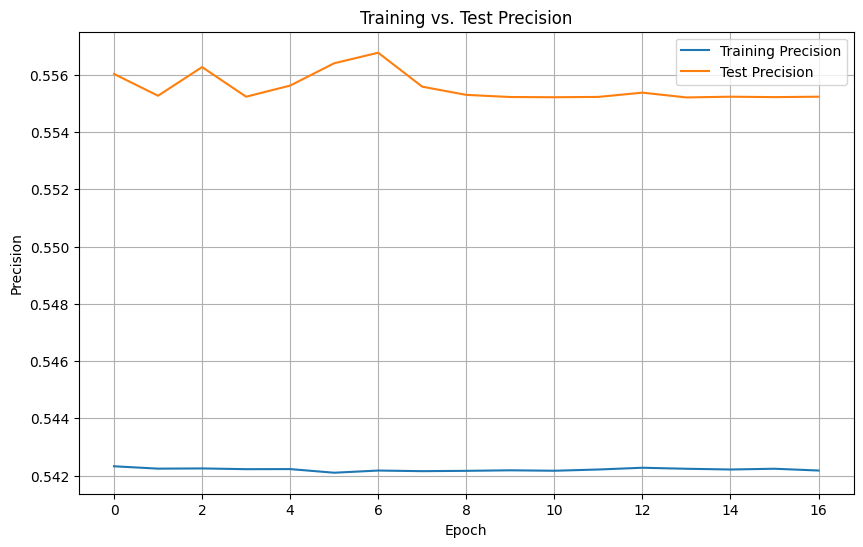

In [ ]:
# Learning visualisation for the Deep Neural Network (DNN)
# The model is not actually training, as the precision and accuracy score are not improving on TRAIN/TEST with more Epochs

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(best_history_nn['precision_4'], label='Training Precision')
plt.plot(best_history_nn['val_precision_4'], label='Test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training vs. Test Precision')
plt.legend()
plt.grid(True)
plt.show()

# 2) Different Decision rules to improve precision (varying threshold)

best model1 (clf_best): Decision Tree (max_depth=15)
best model2 (rf_best): Random Forest (n_estimators=200, max_depth=17)

## 2.1. Predicting probabilities (predict_proba), getting the distribution for probabilities, and new decision rules

In [ ]:
# y_pred_test = best_lr.predict_proba(X_test)

# predicting probability instead of a lable

y_pred_test = clf_best.predict_proba(X_test)
y_pred_test_class1 = [k[1] for k in y_pred_test] # k[1] is the second element in the list of Class predictions

In [ ]:
# example prediction of probabilities
y_pred_test

array([[0.55180962, 0.44819038],
       [0.55180962, 0.44819038],
       [0.55180962, 0.44819038],
       ...,
       [0.51484904, 0.48515096],
       [0.51484904, 0.48515096],
       [0.51484904, 0.48515096]])

In [ ]:
y_pred_test_class1_df = pd.DataFrame(y_pred_test_class1, columns=['Class1_probability'])
y_pred_test_class1_df.head()

,Class1_probability
0,0.44819
1,0.44819
2,0.44819
3,0.44819
4,0.44819


In [ ]:
# Mean prediction is 0.52, median is 0.58, 75% quantile is 0.75
y_pred_test_class1_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Class1_probability,29829.0,0.496955,0.25792,0.0,0.378004,0.570806,0.642896,1.0


In [ ]:
# Unconditional probability of a positive growth is 55.5%
y_test.sum()/y_test.count()

0.5551979617151095

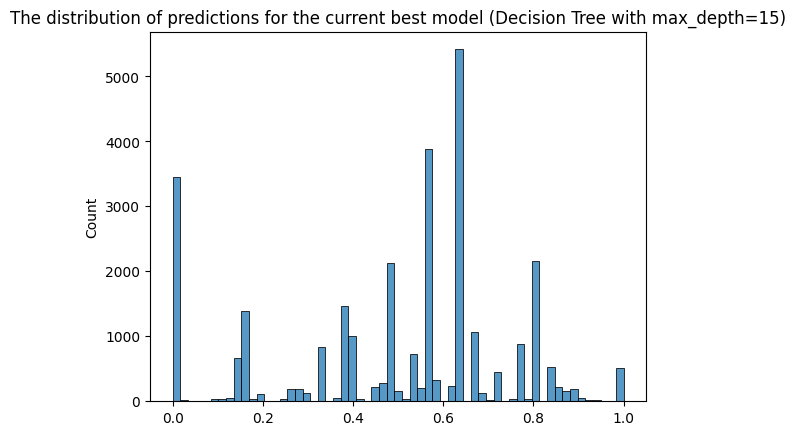

In [ ]:
sns.histplot(y_pred_test_class1)

# Add a title
plt.title('The distribution of predictions for the current best model (Decision Tree with max_depth=15)')

# Show the plot
plt.show()

In [ ]:
# tpr (True Positive Rate) vs. fpr (False Positive Rate) dataframe
# tp = True Positive
# tn = True Negative
# fp = False Positive
# fn = False Negative
# Decision Rule :  "y_pred>= Threshold" for Class "1"

# when only_even=True --> we'll have a step ==0.02 and leave only even records

def tpr_fpr_dataframe(y_true, y_pred, only_even=False):
    scores = []

    if only_even==False:
      thresholds = np.linspace(0, 1, 101) #[0, 0.01, 0.02, ...0.99,1.0]
    else:
      thresholds = np.linspace(0, 1, 51) #[0, 0.02, 0.04,  ...0.98,1.0]

    for t in thresholds:

        actual_positive = (y_true == 1)
        actual_negative = (y_true == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        if tp + fp > 0:
          precision = tp / (tp + fp)

        if tp + fn > 0:
          recall = tp / (tp + fn)

        if precision+recall > 0:
          f1_score = 2*precision*recall / (precision+recall)

        accuracy = (tp+tn) / (tp+tn+fp+fn)

        scores.append((t, tp, fp, fn, tn, precision, recall, accuracy, f1_score))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn','precision','recall', 'accuracy','f1_score']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores


In [ ]:
df_scores = tpr_fpr_dataframe(y_test,
                              y_pred_test_class1,
                              only_even=True)

In [ ]:
# full df_scores
df_scores

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
0,0.00,16561,13268,0,0,0.555198,1.000000,0.555198,0.713990,1.000000,1.000000
1,0.02,14977,11398,1584,1870,0.567848,0.904354,0.564786,0.697643,0.904354,0.859059
2,0.04,14972,11382,1589,1886,0.568111,0.904052,0.565155,0.697751,0.904052,0.857853
3,0.06,14972,11382,1589,1886,0.568111,0.904052,0.565155,0.697751,0.904052,0.857853
4,0.08,14972,11382,1589,1886,0.568111,0.904052,0.565155,0.697751,0.904052,0.857853
5,0.10,14950,11374,1611,1894,0.567923,0.902723,0.564685,0.697213,0.902723,0.857251
6,0.12,14920,11369,1641,1899,0.567538,0.900912,0.563847,0.696383,0.900912,0.856874
7,0.14,14860,11332,1701,1936,0.567349,0.897289,0.563076,0.695156,0.897289,0.854085
8,0.16,13815,10388,2746,2880,0.570797,0.834189,0.559690,0.677804,0.834189,0.782936
9,0.18,13804,10350,2757,2918,0.571500,0.833525,0.560595,0.678079,0.833525,0.780072


In [ ]:
df_scores[(df_scores.threshold>=0.5) & (df_scores.threshold<=0.8)]

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
25,0.50,10095,7210,6466,6058,0.583357,0.609565,0.541520,0.596173,0.609565,0.543413
26,0.52,10068,7197,6493,6071,0.583145,0.607934,0.541051,0.595282,0.607934,0.542433
27,0.54,9676,6888,6885,6380,0.584158,0.584264,0.538268,0.584211,0.584264,0.519144
28,0.56,9536,6795,7025,6473,0.583920,0.575811,0.536692,0.579837,0.575811,0.512134
29,0.58,7035,5135,9526,8133,0.578061,0.424793,0.508498,0.489715,0.424793,0.387021
30,0.60,7003,5113,9558,8155,0.577996,0.422861,0.508163,0.488405,0.422861,0.385363
31,0.62,7003,5103,9558,8165,0.578473,0.422861,0.508498,0.488576,0.422861,0.384610
32,0.64,6796,4826,9765,8442,0.584753,0.410362,0.510845,0.482277,0.410362,0.363732
33,0.66,3724,2735,12837,10533,0.576560,0.224866,0.477958,0.323545,0.224866,0.206135
34,0.68,3110,2283,13451,10985,0.576673,0.187791,0.472527,0.283320,0.187791,0.172068


<Axes: title={'center': 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=15)'}, xlabel='threshold'>

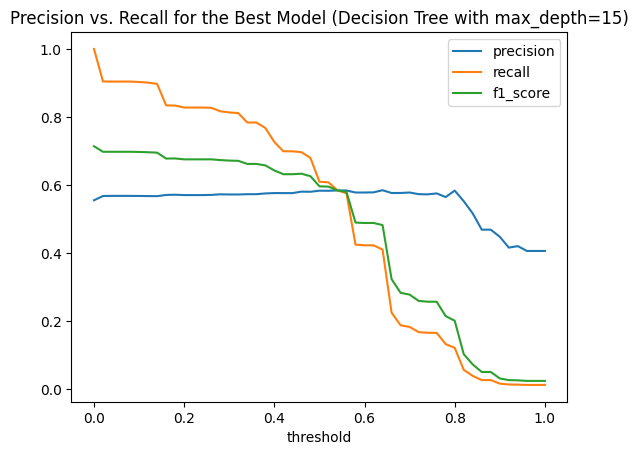

In [ ]:
# Try to find high Precision score points

df_scores.plot.line(x='threshold',
                    y=['precision','recall', 'f1_score'],
                    title = 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=15)')

## 2.2) [Code Snippet 6] Defining new columns with Predictions in new_df: pred7..pred10
* pred7 and pred8 are 2 decision rules for the Decision Tree (best model with max_depth=15)
* pred9 and pred10 are 2 decision rules for the Random Forest (second best model)

In [ ]:
# adding Decision Tree predictors (clf_best) to the dataset for 2 new rules: Threshold = 0.66 and 0.78


y_pred_all = clf_best.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list

# defining a new prediction vector is easy now, as the dimensions will match
new_df['proba_pred7'] = y_pred_all_class1_array
new_df['pred7_clf_best_rule_66'] = (y_pred_all_class1_array >= 0.66).astype(int)

new_df['proba_pred8'] = y_pred_all_class1_array
new_df['pred8_clf_best_rule_78'] = (y_pred_all_class1_array >= 0.78).astype(int)

In [ ]:
# adding Random Forest predictors (rf_best)
rf_best

RandomForestClassifier(max_depth=20, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [ ]:
# adding Random Forest predictors (rf_best) to the dataset for 2 new rules: Threshold = 0.66 and 0.78

y_pred_all = rf_best.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list

# defining a new prediction vector is easy now, as the dimensions will match
new_df['proba_pred9'] = y_pred_all_class1_array
new_df['pred9_rf_best_rule_55'] = (y_pred_all_class1_array >= 0.55).astype(int)

new_df['proba_pred10'] = y_pred_all_class1_array
new_df['pred10_rf_best_rule_60'] = (y_pred_all_class1_array >= 0.6).astype(int)

# TODO HA4 Q1: define new predictor for thresholds 0.51..0.54, 0.56..0.59

In [ ]:
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_gdp_and_fastd',
 'pred4_manual_gdp_and_wti30d',
 'pred5_clf_10',
 'pred6_clf_best',
 'pred7_clf_best_rule_66',
 'pred8_clf_best_rule_78',
 'pred9_rf_best_rule_55',
 'pred10_rf_best_rule_60']

<Axes: >

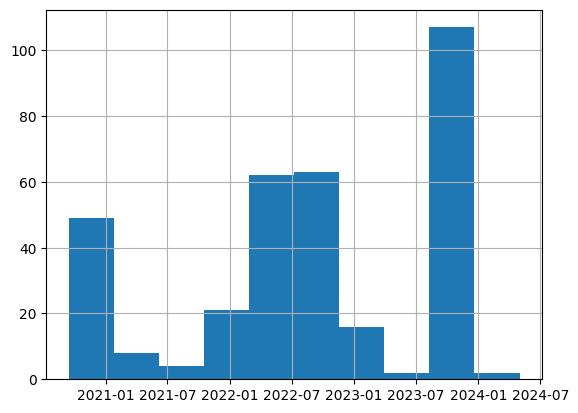

In [ ]:
# When did it predict to trade for the "rare" prediction pred10? (only 2%)
new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_60==1)].Date.hist()

In [ ]:
new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_60==1)].sort_values(by='Date')

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,sim1_net_rev_pred7,sim1_gross_rev_pred8,sim1_fees_pred8,sim1_net_rev_pred8,sim1_gross_rev_pred9,sim1_fees_pred9,sim1_net_rev_pred9,sim1_gross_rev_pred10,sim1_fees_pred10,sim1_net_rev_pred10
6128,219.000000,221.320007,218.300003,219.940002,219.940002,4068800.0,BRK-B,2020,September,0,...,0.000000,-0.000000,0.0,0.000000,-3.146312,-0.2,-3.346312,-0.000000,0.0,0.000000
4818,237.600006,240.990005,236.809998,238.830002,226.498093,1576400.0,ACN,2020,September,0,...,0.000000,-0.000000,0.0,0.000000,-2.060041,-0.2,-2.260041,-2.060041,-0.2,-2.260041
5322,745.799988,750.599976,739.599976,739.799988,722.394592,34579.0,RMS.PA,2020,September,0,...,0.000000,-0.000000,0.0,0.000000,-1.622065,-0.2,-1.822065,-0.000000,0.0,0.000000
2795,364.410004,365.890015,359.350006,362.200012,326.022034,1644700.0,AVGO,2020,September,0,...,0.000000,-0.000000,0.0,0.000000,-1.988601,-0.2,-2.188601,-1.988601,-0.2,-2.188601
3148,205.470001,205.720001,201.720001,202.610001,197.619781,9084100.0,V,2020,September,4,...,0.000000,-0.000000,0.0,0.000000,-2.645498,-0.2,-2.845498,-0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6916,124.059998,125.279999,123.120003,124.959999,121.500748,1080670.0,SIE.DE,2023,October,1,...,0.000000,0.000000,0.0,0.000000,3.137006,-0.2,2.937006,0.000000,0.0,0.000000
5937,22.240000,22.340000,22.129999,22.270000,22.270000,5455000.0,IBN,2023,November,2,...,0.000000,0.000000,0.0,0.000000,1.167491,-0.2,0.967491,1.167491,-0.2,0.967491
8070,65.110001,65.629997,65.040001,65.040001,63.514637,1397100.0,TTE,2023,November,3,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
5340,1031.949951,1031.949951,1007.000000,1013.049988,1013.049988,3804406.0,BHARTIARTL.NS,2024,January,0,...,3.353631,3.553631,-0.2,3.353631,3.553631,-0.2,3.353631,0.000000,0.0,0.000000


In [ ]:
# Pred 10: How many positive prediction per day (out of 33 stocks possible)
pred10_daily_positive_count = pd.DataFrame(new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_60==1)].groupby('Date')['pred10_rf_best_rule_60'].count())

In [ ]:
# Pred 9: How many positive prediction per day (out of 33 stocks possible)
pred9_daily_positive_count = pd.DataFrame(new_df[(new_df.split=='test')&(new_df.pred9_rf_best_rule_55==1)].groupby('Date')['pred9_rf_best_rule_55'].count())

In [ ]:
# Unique trading days on Test (4 years)
new_df[(new_df.split=='test')].Date.nunique()

947

In [ ]:
pred10_daily_positive_count

,pred10_rf_best_rule_60
Date,
2020-09-14,4
2020-09-18,1
2020-09-22,2
2020-09-24,4
2020-10-14,1
...,...
2023-10-31,7
2023-11-01,1
2023-11-09,1


array([[<Axes: title={'center': 'pred10_rf_best_rule_60'}>]], dtype=object)

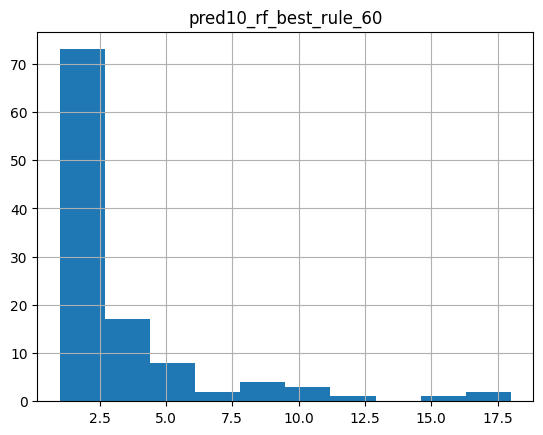

In [ ]:
pred10_daily_positive_count.hist()

In [ ]:
# 75% cases we have not more than 6 bets of $100
pred10_daily_positive_count.describe().T

,count,mean,std,min,25%,50%,75%,max
pred10_rf_best_rule_60,111.0,3.009009,3.415195,1.0,1.0,1.0,3.5,18.0


array([[<Axes: title={'center': 'pred9_rf_best_rule_55'}>]], dtype=object)

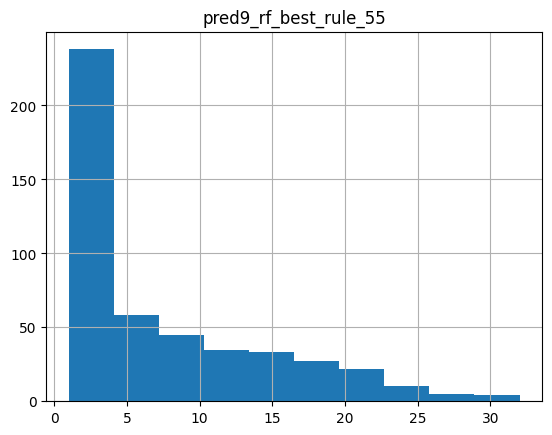

In [ ]:
pred9_daily_positive_count.hist()

In [ ]:
pred9_daily_positive_count.describe().T

,count,mean,std,min,25%,50%,75%,max
pred9_rf_best_rule_55,477.0,7.477987,7.152748,1.0,2.0,5.0,12.0,32.0


## 2.3) Agg. stats on ALL predictions

In [ ]:
# let's review the Predictions:
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict=to_predict)


Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_gdp_and_fastd', 'pred4_manual_gdp_and_wti30d', 'pred5_clf_10', 'pred6_clf_best', 'pred7_clf_best_rule_66', 'pred8_clf_best_rule_78', 'pred9_rf_best_rule_55', 'pred10_rf_best_rule_60']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6', 'is_correct_pred7', 'is_correct_pred8', 'is_correct_pred9', 'is_correct_pred10']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    455
0    344
Name: count, dtype: int64
is_correct_pred0
1    0.569462
0    0.430538
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    8621
0    6980
Name: count, dtype: int64
is_correct_pred1
1    0.552593
0    0.447407
Na

In [ ]:
# Extract number from the prediction column

# Example string
example_string = "pred10_rf_best_rule_60"

# Split the string by '_'
parts = example_string.split('_')

# Extract the part with 'pred' and remove the 'pred' prefix
pred_number = parts[0].replace('pred', '')

# Print the result
print(pred_number)

# Print in one line
print(int(example_string.split('_')[0].replace('pred', '')))


10
10


In [ ]:
# all predictions
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_gdp_and_fastd',
 'pred4_manual_gdp_and_wti30d',
 'pred5_clf_10',
 'pred6_clf_best',
 'pred7_clf_best_rule_66',
 'pred8_clf_best_rule_78',
 'pred9_rf_best_rule_55',
 'pred10_rf_best_rule_60']

In [ ]:
# all predictions on MODELS (not-manual predictions)
PREDICTIONS_ON_MODELS = [p for p in PREDICTIONS if int(p.split('_')[0].replace('pred', ''))>=5]
PREDICTIONS_ON_MODELS

['pred5_clf_10',
 'pred6_clf_best',
 'pred7_clf_best_rule_66',
 'pred8_clf_best_rule_78',
 'pred9_rf_best_rule_55',
 'pred10_rf_best_rule_60']

In [ ]:
# all predictions on Models - correctness
IS_CORRECT_ON_MODELS = [p for p in IS_CORRECT if int(p.replace('is_correct_pred', ''))>=5]
IS_CORRECT_ON_MODELS

['is_correct_pred5',
 'is_correct_pred6',
 'is_correct_pred7',
 'is_correct_pred8',
 'is_correct_pred9',
 'is_correct_pred10']

In [ ]:
# predictions on models
# pred10_rf_best_rule_60: ONLY 2% of TEST cases predicted with high confidence of growth
new_df.groupby('split')[PREDICTIONS_ON_MODELS].agg(['count','sum','mean']).T

split                                 test          train    validation
pred5_clf_10           count  29829.000000  123458.000000  29388.000000
                       sum    25631.000000  100848.000000  27563.000000
                       mean       0.859264       0.816861      0.937900
pred6_clf_best         count  29829.000000  123458.000000  29388.000000
                       sum    17301.000000   79253.000000  22694.000000
                       mean       0.580006       0.641943      0.772220
pred7_clf_best_rule_66 count  29829.000000  123458.000000  29388.000000
                       sum     6459.000000   33623.000000   6710.000000
                       mean       0.216534       0.272344      0.228324
pred8_clf_best_rule_78 count  29829.000000  123458.000000  29388.000000
                       sum     3887.000000   19830.000000   2673.000000
                       mean       0.130309       0.160621      0.090955
pred9_rf_best_rule_55  count  29829.000000  123458.000000  29388.000000
                       sum     3567.000000   65094.000000  17130.000000
                       mean       0.119582       0.527256      0.582891
pred10_rf_best_rule_60 count  29829.000000  123458.000000  29388.000000
                       sum      334.000000   59048.000000  15750.000000
                       mean       0.011197       0.478284      0.535933

In [ ]:
# 10 predictions stats (check TEST set)
new_df.groupby('split')[PREDICTIONS].agg(['count','sum','mean']).T

split                                       test          train    validation
pred0_manual_cci             count  29829.000000  123458.000000  29388.000000
                             sum      799.000000    3162.000000    875.000000
                             mean       0.026786       0.025612      0.029774
pred1_manual_prev_g1         count  29829.000000  123458.000000  29388.000000
                             sum    15601.000000   62117.000000  15585.000000
                             mean       0.523015       0.503143      0.530318
pred2_manual_prev_g1_and_snp count  29829.000000  123458.000000  29388.000000
                             sum    10455.000000   41609.000000  10902.000000
                             mean       0.350498       0.337030      0.370968
pred3_manual_gdp_and_fastd   count  29829.000000  123458.000000  29388.000000
                             sum    29822.000000  107032.000000  29388.000000
                             mean       0.999765       0.866951      1.000000
pred4_manual_gdp_and_wti30d  count  29829.000000  123458.000000  29388.000000
                             sum        0.000000    5673.000000      0.000000
                             mean       0.000000       0.045951      0.000000
pred5_clf_10                 count  29829.000000  123458.000000  29388.000000
                             sum    25631.000000  100848.000000  27563.000000
                             mean       0.859264       0.816861      0.937900
pred6_clf_best               count  29829.000000  123458.000000  29388.000000
                             sum    17301.000000   79253.000000  22694.000000
                             mean       0.580006       0.641943      0.772220
pred7_clf_best_rule_66       count  29829.000000  123458.000000  29388.000000
                             sum     6459.000000   33623.000000   6710.000000
                             mean       0.216534       0.272344      0.228324
pred8_clf_best_rule_78       count  29829.000000  123458.000000  29388.000000
                             sum     3887.000000   19830.000000   2673.000000
                             mean       0.130309       0.160621      0.090955
pred9_rf_best_rule_55        count  29829.000000  123458.000000  29388.000000
                             sum     3567.000000   65094.000000  17130.000000
                             mean       0.119582       0.527256      0.582891
pred10_rf_best_rule_60       count  29829.000000  123458.000000  29388.000000
                             sum      334.000000   59048.000000  15750.000000
                             mean       0.011197       0.478284      0.535933

# 3) Trading Simulations

* create simulation 1 features: like "sim1_pred0" ... "sim1_predLast"

## 3.1) Investing $100 on every positive prediction
* fees = 0.1% for each buy and sell operation ==> 0.2% for buy+sell operation

In [ ]:
# current prediction
pred = 'pred6_clf_best'

In [ ]:
# Total Number of Investment Opportunities
new_df[new_df.split=='test'].Close.count()

29829

In [ ]:
# Total Number of Days (~4 years of trading)
new_df[new_df.split=='test'].Date.nunique()

947

In [ ]:
# check actual future growth with 'growth_future_5d', correctness of the prediction with 'is_positive_growth_5d_future'
TO_PREDICT

['growth_future_5d', 'is_positive_growth_5d_future']

In [ ]:
new_df[['growth_future_5d', to_predict,pred]]

,growth_future_5d,is_positive_growth_5d_future,pred6_clf_best
3490,0.963003,0,1
3491,0.971143,0,1
3492,0.929709,0,1
3493,0.980114,0,1
3494,1.007291,1,1
...,...,...,...
5422,NaN,0,1
5423,NaN,0,0
5424,NaN,0,0
5425,NaN,0,0


In [ ]:
# GROSS REVENUE: ONLY when current_prediction equals to 1: invest $100 into that stock (buy), and sell in 1week (sell)
new_df['sim1_gross_rev_pred6'] = new_df[pred] * 100 * (new_df['growth_future_5d']-1)

In [ ]:
# FEES: 0.1% for each operation , 0.2% for buy+sell ONLY when current_prediction equals to one
new_df['sim1_fees_pred6'] = -new_df[pred] * 100 * 0.002

In [ ]:
# NET REVENUE: GROSS_REVENUE + FEES
new_df['sim1_net_rev_pred6'] = new_df['sim1_gross_rev_pred6'] + new_df['sim1_fees_pred6']

In [ ]:
COLUMNS_FIN_RESULT = ['Date','Ticker','Close']+TO_PREDICT+ [pred,  'sim1_gross_rev_pred6','sim1_fees_pred6','sim1_net_rev_pred6']
new_df[(new_df.split=='test')&(new_df[pred]==1)][COLUMNS_FIN_RESULT]

,Date,Ticker,Close,growth_future_5d,is_positive_growth_5d_future,pred6_clf_best,sim1_gross_rev_pred6,sim1_fees_pred6,sim1_net_rev_pred6
8707,2020-09-28,MSFT,209.440002,1.004488,1,1,0.448812,-0.2,0.248812
8708,2020-09-29,MSFT,207.259995,0.993487,0,1,-0.651332,-0.2,-0.851332
8709,2020-09-30,MSFT,210.330002,0.997623,0,1,-0.237722,-0.2,-0.437722
8710,2020-10-01,MSFT,212.460007,0.991151,0,1,-0.884886,-0.2,-1.084886
8711,2020-10-02,MSFT,206.190002,1.046656,1,1,4.665591,-0.2,4.465591
...,...,...,...,...,...,...,...,...,...
5418,2024-04-24,LT.NS,3634.850098,0.990275,0,1,-0.972532,-0.2,-1.172532
5419,2024-04-25,LT.NS,3652.300049,0.958245,0,1,-4.175451,-0.2,-4.375451
5420,2024-04-26,LT.NS,3605.199951,0.960640,0,1,-3.935979,-0.2,-4.135979
5421,2024-04-29,LT.NS,3634.300049,0.943166,0,1,-5.683352,-0.2,-5.883352


In [ ]:
# DAILY INVESTMENTS COUNT
filter_test_and_positive_pred = (new_df.split=='test')&(new_df[pred]==1)
df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
sim1_avg_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
print(sim1_avg_investments_per_day)

33.0


In [ ]:
# Distribution: how many times do we trade daily (for the current Prediction)?
df_investments_count_daily.describe().T

,count,mean,std,min,25%,50%,75%,max
pred6_clf_best,680.0,25.442647,10.980084,1.0,19.0,32.0,33.0,33.0


In [ ]:
new_df[(new_df.split=='test')&(new_df[pred]==1)][['sim1_gross_rev_pred6','sim1_fees_pred6','sim1_net_rev_pred6']].sum()

sim1_gross_rev_pred6    12182.085986
sim1_fees_pred6         -3460.200000
sim1_net_rev_pred6       8728.485986
dtype: float64

### 3.1.2 Calculate fin. results for all fields
* Simplified and approximate calculation

In [ ]:
# Calculate fin. result for ALL predictions (manual and produced by models)

sim1_results = [] # results in Array

# Iterate over all predictions
for pred in PREDICTIONS:
  print(f'Calculating sumulation for prediction {pred}:')
  print(f"    Count times of investment {len(new_df[(new_df.split=='test')&(new_df[pred]==1)])} out of {len(new_df[(new_df.split=='test')])} TEST records")

  # Prefix: e.g. pred1 or pred10
  pred_prefix= pred.split('_')[0]

  # Fin. result columns: define new records for EACH positive prediction
  new_df['sim1_gross_rev_'+pred_prefix] = new_df[pred] * 100 * (new_df['growth_future_5d']-1)
  new_df['sim1_fees_'+pred_prefix] = -new_df[pred] * 100 * 0.002
  new_df['sim1_net_rev_'+pred_prefix] = new_df['sim1_gross_rev_'+pred_prefix] + new_df['sim1_fees_'+pred_prefix]

  # calculate agg. results for each PREDICTION columns (pred) on TEST
  filter_test_and_positive_pred = (new_df.split=='test')&(new_df[pred]==1) # filter records on TEST set, when current prediction is 1 (we invest $100 for 1 week ahead - 5 periods)
  sim1_count_investments = len(new_df[filter_test_and_positive_pred])
  sim1_gross_rev = new_df[filter_test_and_positive_pred]['sim1_gross_rev_'+pred_prefix].sum()
  sim1_fees = new_df[filter_test_and_positive_pred]['sim1_fees_'+pred_prefix].sum()
  sim1_net_rev = new_df[filter_test_and_positive_pred]['sim1_net_rev_'+pred_prefix].sum()

  if sim1_gross_rev>0:
    sim1_fees_percentage = -sim1_fees/sim1_gross_rev
  else:
    sim1_fees_percentage = None

  if sim1_count_investments>0:
    sim1_average_net_revenue = sim1_net_rev/sim1_count_investments
  else:
    sim1_average_net_revenue = None

  # APPROXIMATE CAPITAL REQUIRED and CAGR Calculation
  df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
  sim1_avg_investments_per_day = df_investments_count_daily[pred].mean()
  sim1_q75_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
  # df_investments_count_daily[pred].mean()
  sim1_capital = 100 * 5 * sim1_q75_investments_per_day # 5 days in a row with positive predictions
  # CAGR: average growth per year. E.g. if you have 1.5 return (50% growth in 4 years) --> (1.5)**(1/4) = 1.106 or 10.6% average
  sim1_CAGR = ((sim1_capital+sim1_net_rev)/sim1_capital)**(1/4)

  # append to DF
  sim1_results.append((pred,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR))


  # output for all predictions with some positive predictions
  if  sim1_count_investments>1:
    print(f"    Financial Result: \n {new_df[filter_test_and_positive_pred][['sim1_gross_rev_'+pred_prefix,'sim1_fees_'+pred_prefix,'sim1_net_rev_'+pred_prefix]].sum()}")
    print(f"        Count Investments in 4 years (on TEST): {sim1_count_investments}")
    print(f"        Gross Revenue: ${int(sim1_gross_rev)}")
    print(f"        Fees (0.2% for buy+sell): ${int(-sim1_fees)}")
    print(f"        Net Revenue: ${int(sim1_net_rev)}")
    print(f"        Fees are {int(-100.0*sim1_fees/sim1_gross_rev)} % from Gross Revenue")
    print(f"        Capital Required : ${int(sim1_capital)} (Vbegin)")
    print(f"        Final value (Vbegin + Net_revenue) : ${int(sim1_capital + sim1_net_rev)} (Vfinal)")

    print(f"        Average CAGR on TEST (4 years) : {np.round(sim1_CAGR,3)}, or {np.round(100.0*(sim1_CAGR-1),1)}% ")

    print(f"        Average daily stats: ")
    print(f"            Average net revenue per investment: ${np.round(sim1_net_rev/sim1_count_investments,2)} ")
    print(f"            Average investments per day: {int(np.round(sim1_avg_investments_per_day))} ")
    print(f"            Q75 investments per day: {int(np.round(sim1_q75_investments_per_day))} ")
    print('=============================================+')


# results in a DataFrame from an Array
columns_simulation = ['prediction', 'sim1_count_investments', 'sim1_gross_rev', 'sim1_fees', 'sim1_net_rev', 'sim1_fees_percentage','sim1_average_net_revenue','sim1_avg_investments_per_day','sim1_capital','sim1_CAGR']

df_sim1_results = pd.DataFrame(sim1_results,columns=columns_simulation)

Calculating sumulation for prediction pred0_manual_cci:
    Count times of investment 799 out of 29829 TEST records
    Financial Result: 
 sim1_gross_rev_pred0    309.04589
sim1_fees_pred0        -159.80000
sim1_net_rev_pred0      149.84589
dtype: float64
        Count Investments in 4 years (on TEST): 799
        Gross Revenue: $309
        Fees (0.2% for buy+sell): $159
        Net Revenue: $149
        Fees are 51 % from Gross Revenue
        Capital Required : $1000 (Vbegin)
        Final value (Vbegin + Net_revenue) : $1149 (Vfinal)
        Average CAGR on TEST (4 years) : 1.036, or 3.6% 
        Average daily stats: 
            Average net revenue per investment: $0.19 
            Average investments per day: 2 
            Q75 investments per day: 2 
=============================================+
Calculating sumulation for prediction pred1_manual_prev_g1:
    Count times of investment 15601 out of 29829 TEST records
    Financial Result: 
 sim1_gross_rev_pred1    6913.217124


In [ ]:
df_sim1_results['sim1_growth_capital_4y'] = (df_sim1_results.sim1_net_rev+df_sim1_results.sim1_capital) / df_sim1_results.sim1_capital

In [ ]:
# final comparison
df_sim1_results

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
0,pred0_manual_cci,799,309.045890,-159.8,149.845890,0.517075,0.187542,1.866822,1000.0,1.035523,1.149846
1,pred1_manual_prev_g1,15601,6913.217124,-3120.2,3812.817124,0.451338,0.244396,16.526483,11000.0,1.077237,1.346620
2,pred2_manual_prev_g1_and_snp,10455,4213.424501,-2091.0,2139.624501,0.496271,0.204651,21.918239,13000.0,1.038826,1.164587
3,pred3_manual_gdp_and_fastd,29822,14893.285316,-5964.4,8961.885316,0.400476,0.300513,31.491024,16500.0,1.114555,1.543145
4,pred4_manual_gdp_and_wti30d,0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
5,pred5_clf_10,25631,15693.743691,-5126.2,10600.543691,0.326640,0.413583,31.295482,16500.0,1.132071,1.642457
6,pred6_clf_best,17301,12182.085986,-3460.2,8728.485986,0.284040,0.504508,25.442647,16500.0,1.111992,1.528999
7,pred7_clf_best_rule_66,6459,3842.337625,-1291.8,2553.137625,0.336202,0.395284,19.692073,16000.0,1.037706,1.159571
8,pred8_clf_best_rule_78,3887,1844.823960,-777.4,1067.423960,0.421395,0.274614,15.865306,15500.0,1.016789,1.068866
9,pred9_rf_best_rule_55,3567,3401.051204,-713.4,2690.451204,0.209759,0.754262,7.477987,6000.0,1.097041,1.448409


In [ ]:
print('CAGR for pred5_clf_10 :', np.round(df_sim1_results[df_sim1_results['prediction']=='pred5_clf_10']['sim1_CAGR'].values[0],4))

CAGR for pred5_clf_10 : 1.1321


In [ ]:
# Create the scatter plot
fig = px.scatter(
    df_sim1_results.dropna(),
    x='sim1_avg_investments_per_day',
    y='sim1_CAGR',
    size='sim1_growth_capital_4y',  # Use the 'size' parameter for sim1_CAGR
    text='prediction',
    title='Compound Annual Growth vs. Time spent (Average investments per day)',
    labels={'sim1_capital': 'Initial Capital Requirement', 'growth_capital_4y': '4-Year Capital Growth'}
)

# Update the layout to improve readability of the annotations
fig.update_traces(textposition='top center')

# Show the plot
fig.show()